# Exploring Over 5 Years of NordPool Data

### Introduction

This is an analysis of hourly electricity spot price data in the Nordics (excl. Iceland) and the Baltics. The data is freely available on https://www.nordpoolgroup.com/historical-market-data/.

NordPool was established in 1993 by the Norwegian TSO Statnett after the Norwegian parliament decided to deregulate the electricity market in 1991. This was the first deregulated market in the world, and NordPool expanded in 1996 to also cover the Swedish market. In 1998 Finland joined, and in 2000 Denmark also became part of the join electricity trade market. 


This analysis is created by Rasmus Vester Thøgersen and made available on GitHub through the MIT License. Link to the GitHub-repository: https://github.com/rasmusthog/nordpool-data-analysis

# 1. Importing data and EDA

Let's start importing the data and doing some exploratory data analysis (EDA). 

The data has been cleaned using a seperate script called "import_data.py", available at the GitHub repository. This imports the hourly elspot price files in .CSV-format (manually exported from .XLS due to some import errors), cleans the data and concatenates the files into a single .CSV-file containing data from 2013-2018.

count    48863.000000
mean        30.194939
std          9.662997
min          1.140000
25%         24.740000
50%         29.570000
75%         35.370000
max        199.970000
Name: SYS, dtype: float64


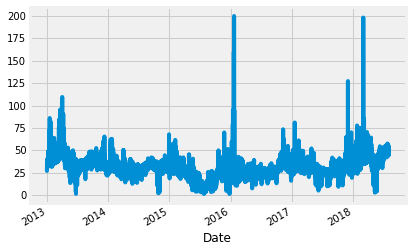

In [31]:
# importing modules
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# importing full dataset

elspot_df = pd.read_csv("datasets/total-elspot-prices_2013-2018.csv", delimiter=",", header=0, index_col="Date", parse_dates=True)

# Look at the description and visual plot of the system price.
print(elspot_df["SYS"].describe())
elspot_df["SYS"].plot()


# Create a dataframe containing only daily data that will be expanded throughout the analysis
elspot_df_daily = elspot_df.resample("1d").mean()


We're working with a large dataset of 48863 entries, one for each hour since 1st January 2013. The system price mean is 30.19€ with a standard deviation of 9.66€. The system price has been as high as 199.97€, and as low as 1.14€.

The maximum values are shown as two very large peaks, and there is also one slightly smaller. These two large peaks occured on 21st January 2016 (at 08:00 and 18:00) and 1st March 2018 (at 08:00). These peak correspond to about 7 times the mean elspot price. After having contacted NordPool, they confirmed that this data is real and is due to high congestion in the system, due to limited transmission capacity, planned downtime on transmission lines, large consumption peaks or downtime on a large production facility. 

As these peaks are real data, I will not do anything to remove them (at least not at this point).

### Investigating how daylight saving time is handled

There are two dates a year where we change to and from daylight saving time. We enter daylight saving time the last Sunday of October, and leave it the last Sunday in March. Let's find out how this is handled in this dataset.

In [32]:
# Let's find the dates for the last Sunday in March and October each year.

dates_df = elspot_df[["SYS"]]
dates_df = dates_df.resample("D").mean()
dates_df["Day"] = dates_df.index.weekday

years = [2013, 2014, 2015, 2016, 2017, 2018]

#Initalise empty list for dates we enter daylight saving time.
enter_dls = []
    
for year in years:
    # Repeat for enter daylight saving time
    date_str_start = "%d-10-25" % year
    date_str_end = "%d-10-31" % year
    
    # Add condition that year is not 2018, as data for October does not exist
    if year != 2018:
        df_subset_enter = dates_df.loc[date_str_start:date_str_end]
        enter_dls.append((year, df_subset_enter["Day"].idxmax().day))

# Initialise empty list for dates we exit daylight saving time
exit_dls = []

# Get dates for enter and exit daylight saving time 
for year in years:
    # Get exit daylight saving time dates
    date_str_start = "%d-03-25" % year
    date_str_end = "%d-03-31" % year
    
    df_subset_exit = dates_df.loc[date_str_start:date_str_end]
    
    exit_dls.append((year, df_subset_exit["Day"].idxmax().day))

# Create strings for .loc for March 
datestr_exit = []
for year, date in exit_dls:
    date_str = "%d-03" % year
    date_str = date_str + "-%d" % date
    datestr_exit.append(date_str)

# Create strings for .loc for October
datestr_enter = []
for year, date in enter_dls:
    date_str = "%d-03" % year
    date_str = date_str + "-%d" % date
    datestr_enter.append(date_str)

    

# Investigating what happens when we EXIT daylight saving time
#for date in datestr_exit:
#    print(elspot_df["SYS"].loc[date].head())
    
# Investigating what happens when we ENTER daylight saving time
#for date in datestr_enter:
#    print(elspot_df["SYS"].loc[date].head())

By running the commented code in the cell above, we can see that the missing hour as we exit daylight saving time in March is handled by using the NaN value for the hour between 02:00 and 03:00. The double hour as we enter daylight saving time in October is only listed once, and as the hour has values resembling the hours before and after, it is either the average of the two, or the bidding is only for one hour and both hours are imposed with the same price. 

As the extra hours in March is NaN for all columns, we will just drop these rows.

In [33]:
# Dropping the rows with NaN
elspot_df = elspot_df.dropna()

# 2. Investigating differences _within_ countries

Each country may have several bidding areas, or price regions. These are decided by the local transmission system operator (TSO), and are subject to change over time. Today, the following bidding areas exist: 

- Norway: NO1, NO2, NO3, NO4, NO5
- Sweden: SE1, SE2, SE3, SE4
- Denmark: DK1, DK2
- Finland: FI
- Latvia: LV
- Lithuania: LT
- Estonia: EE

<img src="img/bidding-areas.png" width="400px">


The reason for the division is due to the limited transmission capacity between different geographical areas, as flow may be congested and price differences may help curb demand or up supply in congested areas. 

First, let's define some new columns which will make the dataset easier to work with.

In [34]:
# Define style for graphs
plt.style.use("fivethirtyeight")

# Create lists of zones specific to each country. Baltics and Finland is grouped together as
# each country as one zone only
norway = ["NO1", "NO2", "NO3", "NO4", "NO5"]
sweden = ["SE1", "SE2", "SE3", "SE4"]
denmark = ["DK1", "DK2"]
baltics = ["LV", "LT", "EE"]
finland = ["FI"]
nordics = norway + sweden + denmark + finland

# Add means of each country / area to own column in hourly dataframe
elspot_df["Norway"] = elspot_df[norway].mean(axis=1)
elspot_df["Sweden"] = elspot_df[sweden].mean(axis=1)
elspot_df["Denmark"] = elspot_df[denmark].mean(axis=1)
elspot_df["Finland"] = elspot_df[finland].mean(axis=1) # this is superfluous but is added for clarity and ease of use
elspot_df["Nordics"] = elspot_df[nordics].mean(axis=1)
elspot_df["Baltics"] = elspot_df[baltics].mean(axis=1)

# Add means of each country / area to own column in daily dataframe
elspot_df_daily["Norway"] = elspot_df_daily[norway].mean(axis=1)
elspot_df_daily["Sweden"] = elspot_df_daily[sweden].mean(axis=1)
elspot_df_daily["Denmark"] = elspot_df_daily[denmark].mean(axis=1)
elspot_df_daily["Finland"] = elspot_df_daily[finland].mean(axis=1) # this is superfluous but is added for clarity and ease of use
elspot_df_daily["Nordics"] = elspot_df_daily[nordics].mean(axis=1)
elspot_df_daily["Baltics"] = elspot_df_daily[baltics].mean(axis=1)

Let's investigate the evolution of the prices in the different countries, and compare to the mean overall system price (marked with a red horizontal line) for the past 5,5 years. In order to smoothe out the large fluctuations we may have due to the high resolution of the data (hourly), the data has been averaged using a rolling window mean of 60 days. This makes it easier to distinguish the general patterns of how the price moves.

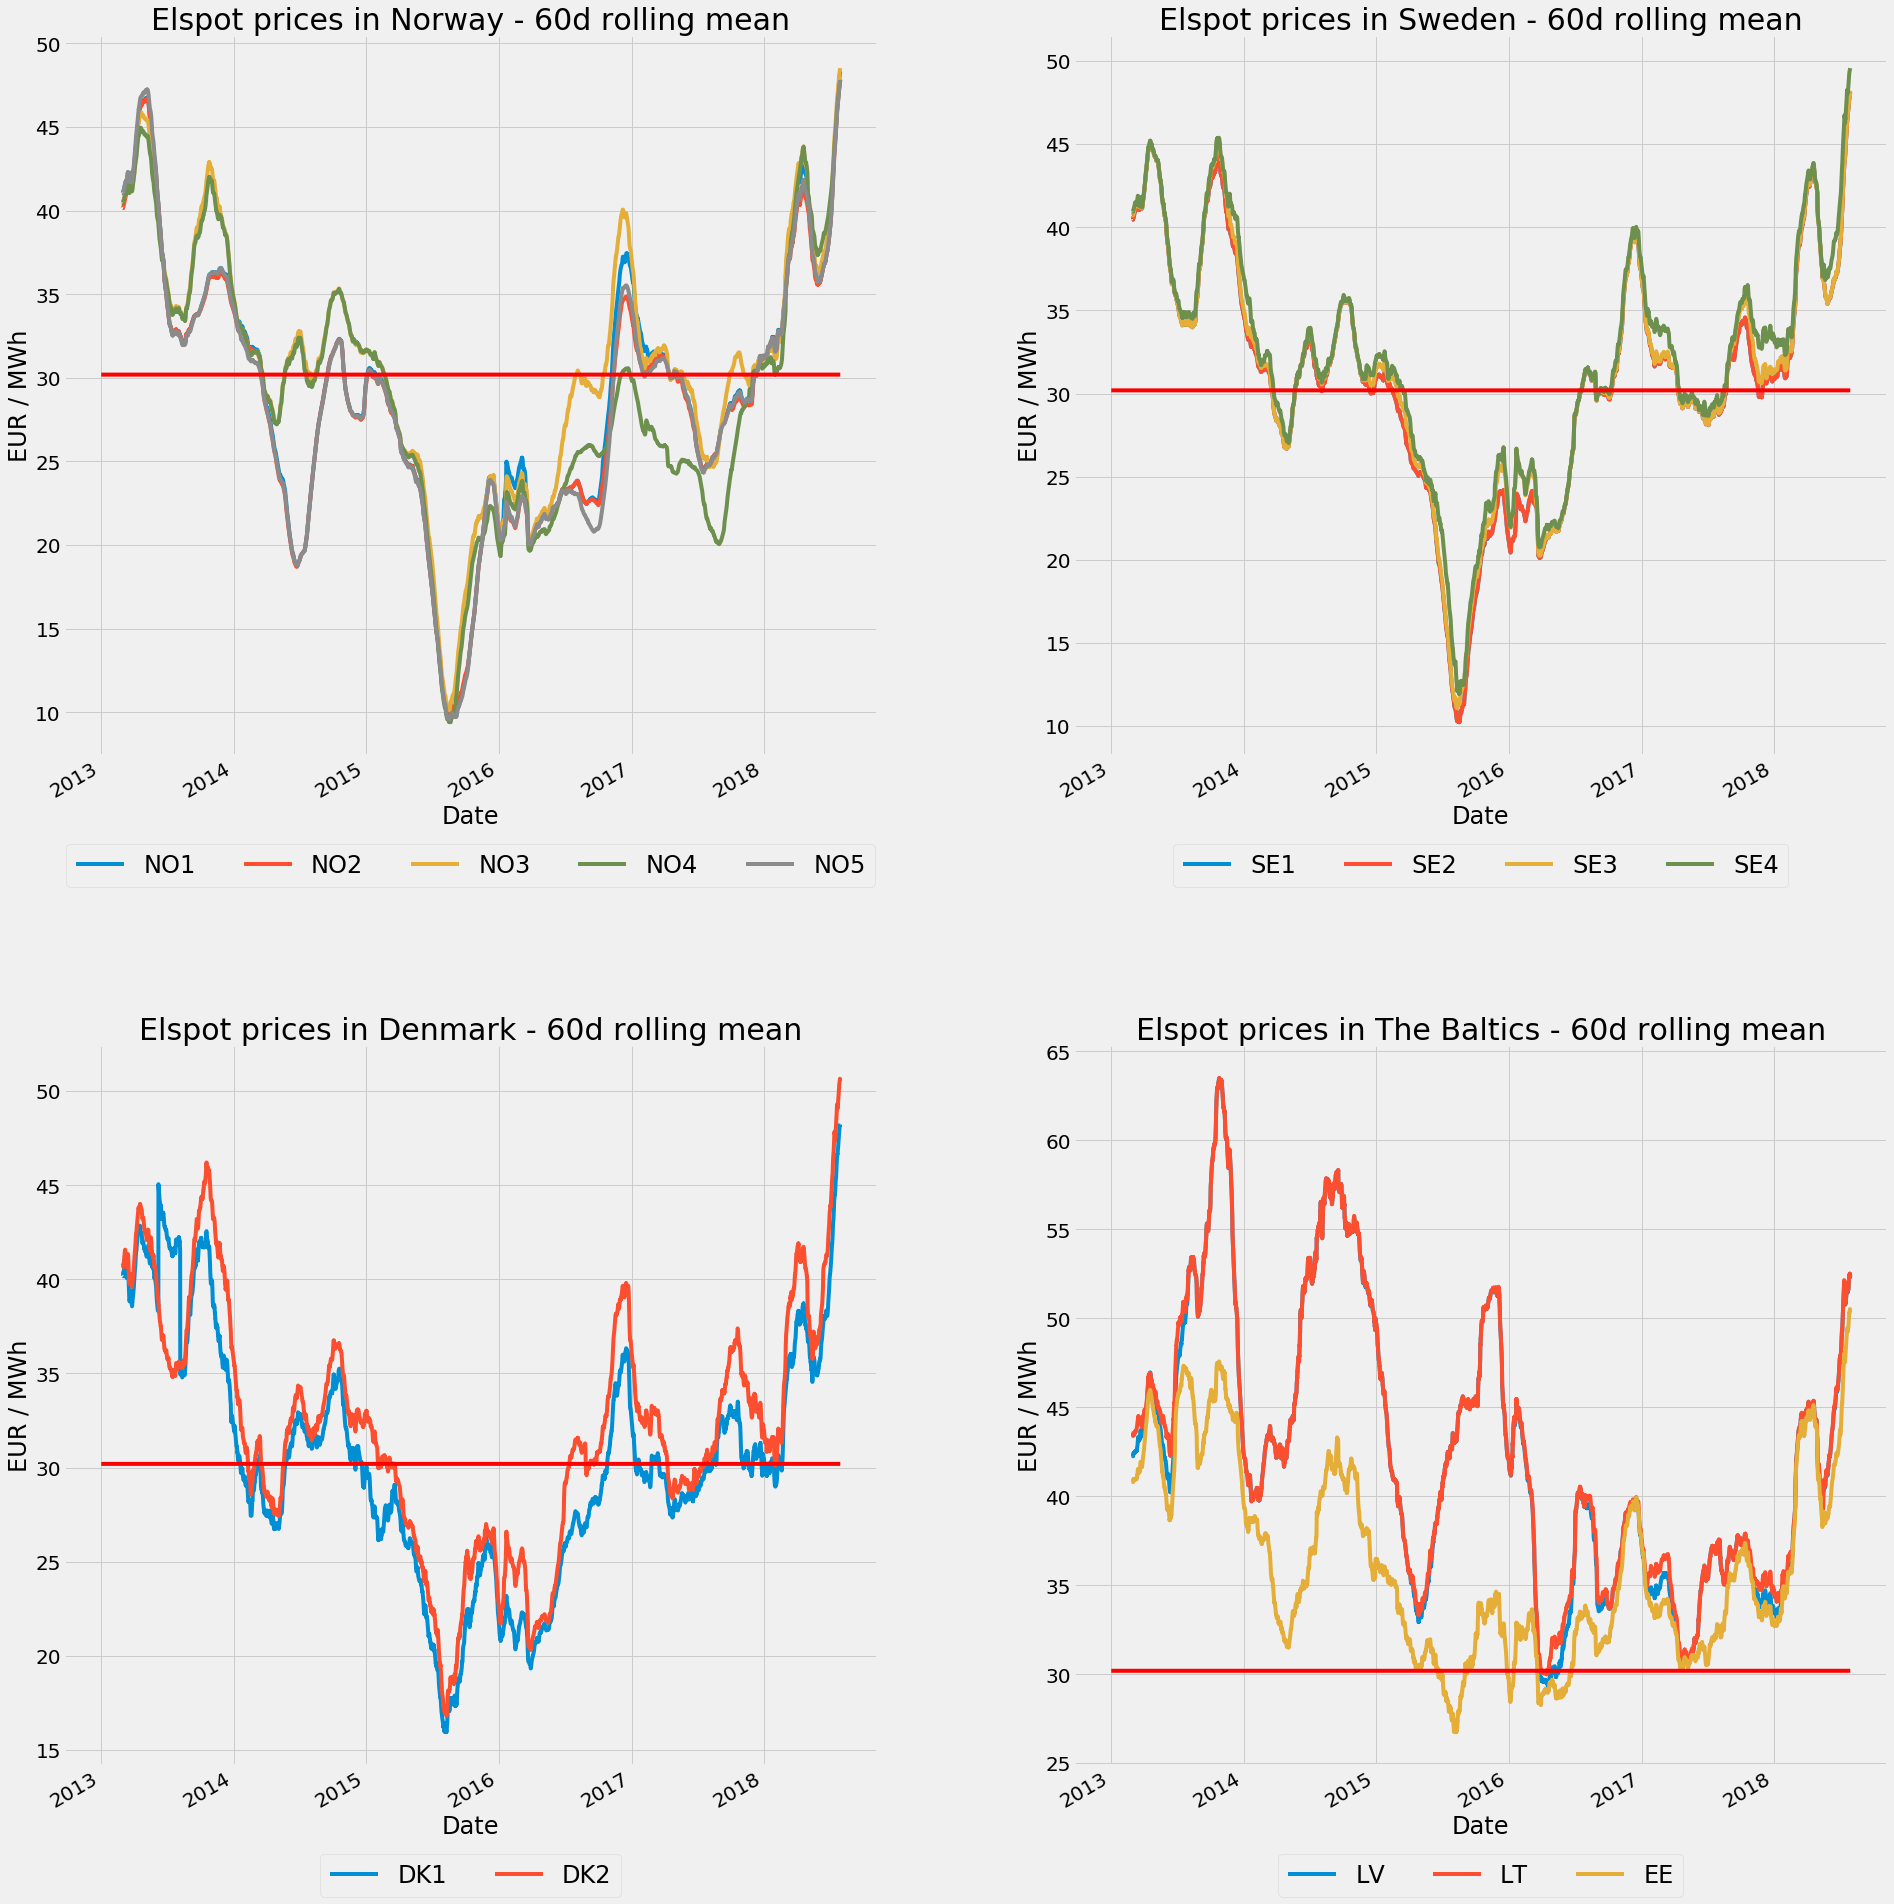

In [35]:
# Make 60 day moving window average of prices to smooth out the curves. 
# Requiring the mean to be made up of 2 months of observations.
elspot_df_smoothed = elspot_df.rolling("60d", min_periods=1439).mean()

# Plot Norway
plt.subplot(2,2,1)

for zone in norway:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 60]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Norway - 60d rolling mean", fontsize=30)

# Plot Sweden
plt.subplot(2,2,2)

for zone in sweden:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Sweden - 60d rolling mean", fontsize=30)

# Plot Denmark
plt.subplot(2,2,3)

for zone in denmark:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in Denmark - 60d rolling mean", fontsize=30)

# Plot Baltics 
plt.subplot(2,2,4)

for zone in baltics:
    ax = elspot_df_smoothed[zone].plot(linewidth=4, figsize=(30,30))
    #ax.set_ylim([0, 120]) # trying to avoid the large peaks
    
    
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=5, fontsize=24)
ax.set_ylabel("EUR / MWh", fontsize=24)
ax.set_xlabel("Date", fontsize=24)
ax.tick_params(axis="both", labelsize=20)
elspot_df["SYS_mean"] = elspot_df["SYS"].mean()
ax.plot(elspot_df["SYS_mean"], color="r")
ax.set_title("Elspot prices in The Baltics - 60d rolling mean", fontsize=30)


plt.tight_layout(pad=10)

There are of some interesting observations from this. First of all, there are clear price differences within each country, except for **Sweden** where the four bidding areas have approximately the same price for most of the period we're looking at. In **Norway**, there's a large discrepancy between the prices, except in certain periods where the price is very similar. In **Denmark**, the eastern bidding area consistently lies above the western, and in the **Baltics**, Latvia and Lithuenia has historically experienced much larger prices than in Estonia, however, this seems to have changed the past year. **Finland** has been at a level below the Baltics, but they are all generally well above the mean system price.

Looking at the average prices in the different countries (treating The Baltics and Finland as one area still), we see that the prices in Norway generally are below the others, though for a large amount of the time folowing the price in Sweden and Denmark quite well.

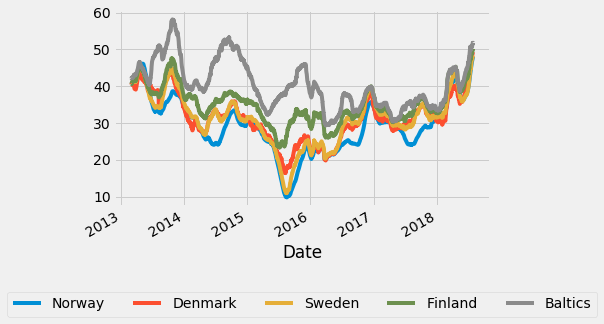

In [36]:
ax = elspot_df_smoothed[["Norway", "Denmark", "Sweden", "Finland", "Baltics"]].plot()
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=5, fontsize=14)


# 4. Time of day

#### Extracting extrema values for each day

First, let's extract all the maximum and minimum values for each day and see when they occur during the day.

In [44]:
# Extract max and min for each day into the daily dataframe

# Get list of column names, and remove last entry "SYS_mean"
column_names = np.delete(elspot_df.columns.values, -1)

# Iterate over each column to find max and min and add to new columns in daily dataframe
for column in column_names:
    
    # Create strings for new column names
    new_col_max = column + "_max"
    new_col_max_hour = column + "_max_hour"
    
    new_col_min = column + "_min"
    new_col_min_hour = column + "_min_hour"

    # Extract maximum value for each day and hour of day this occurs
    elspot_df_temp = elspot_df[[column]] # Create temporary dataframe to avoid indexing error
    temp_df = elspot_df_temp.loc[elspot_df_temp.groupby(pd.Grouper(freq="1d")).idxmax().iloc[:, 0]]
    temp_df["Hour"] = temp_df.index.hour
    temp_df = temp_df.resample("1d").mean()

    elspot_df_daily[new_col_max] = temp_df[column]
    elspot_df_daily[new_col_max_hour] = temp_df["Hour"]
    
    # Extract minimum value for each day and hour of day this occurs
    temp_df = elspot_df_temp.loc[elspot_df_temp.groupby(pd.Grouper(freq="1d")).idxmin().iloc[:, 0]]
    temp_df["Hour"] = temp_df.index.hour
    temp_df = temp_df.resample("1d").mean()
    
    elspot_df_daily[new_col_min] = temp_df[column]
    elspot_df_daily[new_col_min_hour] = temp_df["Hour"]



['DK1' 'DK2' 'EE' 'FI' 'LT' 'LV' 'NO1' 'NO2' 'NO3' 'NO4' 'NO5' 'SE1' 'SE2'
 'SE3' 'SE4' 'SYS' 'Norway' 'Sweden' 'Denmark' 'Finland' 'Nordics'
 'Baltics']


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Plotting the frequency of max/min occurences
Now we have extracted all the maxima and minima, and when this occurs, we can now look at the time of day for when these extrema occur. Let's plot this data as histograms:

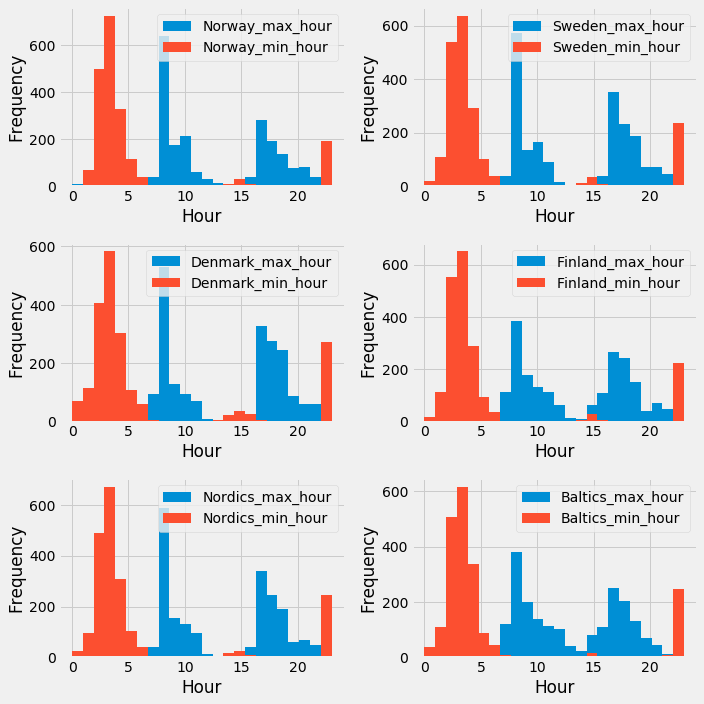

In [45]:
# Plot counts of max and min occurences by time of day for Norway

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(321)
elspot_df_daily[["Norway_max_hour", "Norway_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

ax = fig.add_subplot(322)
elspot_df_daily[["Sweden_max_hour", "Sweden_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

ax = fig.add_subplot(323)
elspot_df_daily[["Denmark_max_hour", "Denmark_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

ax = fig.add_subplot(324)
elspot_df_daily[["Finland_max_hour", "Finland_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

ax = fig.add_subplot(325)
elspot_df_daily[["Nordics_max_hour", "Nordics_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

ax = fig.add_subplot(326)
elspot_df_daily[["Baltics_max_hour", "Baltics_min_hour"]].plot(kind="hist", bins=24, ax=ax)
ax.set_xlabel("Hour")

# Tighten layout
plt.tight_layout()

Looking at the different profiles for when the maxima and minima occur for the (country mean) spot price, there doesn't seem to be a big difference between the different regions. The minima usually occurs during night starting at 23:00 and lasting until 06:00, with a clear peak at 02:00-04:00 for every country. Every country also has a strange peak at 23:00 before going down at 00:00, which should be investaged further - could be error in the code, or could actually be real. 

What about the peaks of minimum price that happens at 23:00? Is this real, or is there something wrong with the data / handling of data?

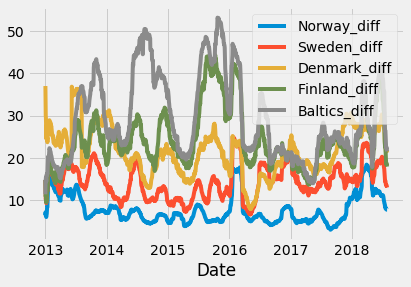

In [53]:
# Finding which dates the minimum at 23:00 occurs
elspot_df_peak_norway = elspot_df_daily.loc[elspot_df_daily["Norway_min_hour"] == 23]

#print(elspot_df_peak_norway["Norway"].loc["2016"])

# Exploring some of the dates where the minum occurs at 23:00

fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(221)
# print(elspot_df["Norway"].loc["2013-01-18"])
elspot_df["Norway"].loc["2013-01-18":"2013-01-19"].plot(ax=ax1)
ax1.set_title("Random check in 2013")

ax2 = fig.add_subplot(222)
# print(elspot_df["Norway"].loc["2014-04-12"])
elspot_df["Norway"].loc["2014-04-12":"2014-04-13"].plot(ax=ax2)
ax2.set_title("Random check in 2014")

ax3 = fig.add_subplot(223)
# print(elspot_df["Norway"].loc["2015-09-05"])
elspot_df["Norway"].loc["2015-09-05":"2015-09-05"].plot(ax=ax3)
ax3.set_title("Random check in 2015")

ax4 = fig.add_subplot(224)
# print(elspot_df["Norway"].loc["2016-02-27"])
elspot_df["Norway"].loc["2016-02-27":"2016-02-28"].plot(ax=ax4)
ax4.set_title("Random check in 2016")

plt.tight_layout()

It seems that the occurences of the minima at 23:00 are due to the lower prices the following night. 

#### Investigating the difference between maximum and minimum price in the different countries

Next we'll look at the difference between the maximum and minimum price within a day is for the different countries and areas. We will again look at Norway, Sweden, Denmark, Finaland and the Baltics. 

This difference says something about the possibility for arbitrage in the power market, if you were to set up some sort of electricity storage (pumped hydro reservoirs, battery banks, etc.). In these cases you could purchase power cheaply during off-peak hours, store it and sell it during peak-hours for a larger price. The difference between the price you'd buy at (minimum) and the price you'd sell at (maximum) would determine the profit you could make for such an operation.

Note that the this is not an attempt to quantify how much you could possibly earn doing this. That would require additional information about the nature of your storage unit such as how fast you could charge your storage device, how fast you could discharge your storage device and the prices over the timescales necessary to charge and discharge. 

In [ ]:
diff_columns = []

for column in column_names:
    max_col = column + "_max"
    min_col = column + "_min"
    diff_col = column + "_diff"
    diff_columns.append(diff_col)
    
    elspot_df_daily[diff_col] = elspot_df_daily[max_col] - elspot_df_daily[min_col]


elspot_df_diff_smoothed = elspot_df_daily[diff_columns].rolling("60d").mean()

elspot_df_diff_smoothed[["Norway_diff", "Sweden_diff", "Denmark_diff", "Finland_diff", "Baltics_diff"]].plot()

As can be seen, the difference is much less in Norway than in the other countries, with Sweden having the second lowest difference. This could very well be due to pumped hydro storage, which allows the producers to use the electricity generated (or purchase cheap power) to pump water back into reservoirs.

#### Standard deviation of prices within each day

What about the standard deviation within each day?

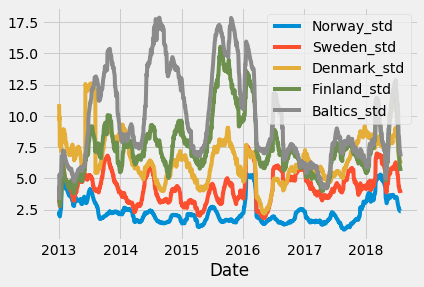

In [56]:
# Add standard deviation columns to the dataframe.

std_columns = []

for column in column_names:
    new_col = column + "_std"
    std_columns.append(new_col)
    
    elspot_df_daily[new_col] = elspot_df[column].resample("1d").std()
    
    
elspot_df_std_smoothed = elspot_df_daily[std_columns].rolling("60d").mean()

elspot_df_std_smoothed[["Norway_std", "Sweden_std", "Denmark_std", "Finland_std", "Baltics_std"]].plot()

# 5. Seasonal variations

Let's look at seasonal variations, and how the prices change from months to month and quarter to quarter.

In [ ]:
# Extract years in different dataframes
elspot_df_2014 = elspot_df.loc["2014"]
elspot_df_2015 = elspot_df.loc["2015"]
elspot_df_2016 = elspot_df.loc["2016"]
elspot_df_2017 = elspot_df.loc["2017"]
elspot_df_2018 = elspot_df.loc["2018"]

# 

#print(elspot_df[["Molde", "Trondheim"]].head(48))


# look at difference between max and min in different seasons



# 6. Interconnections